In [2]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 65.6 MB/s eta 0:00:00


In [43]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import matplotlib.pyplot as plt

In [44]:
dev = qml.device("default.qubit", wires=2)

In [45]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

In [46]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

In [56]:
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss


def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)


In [58]:
def dataset(filename):
  data = np.loadtxt(filename)
  X = data[:, 0:2]
  print("First X sample (original)  :", X[0])

  # pad the vectors to size 2^2 with constant values
  padding = 0.3 * np.ones((len(X), 1))
  X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
  print("First X sample (padded)    :", X_pad[0])

  # normalize each input
  normalization = np.sqrt(np.sum(X_pad ** 2, -1))
  X_norm = (X_pad.T / normalization).T
  print("First X sample (normalized):", X_norm[0])

  # angles for state preparation are new features
  features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
  print("First features sample      :", features[0])

  Y = data[:, -1]

  np.random.seed(0)
  num_data = len(Y)
  num_train = int(0.75 * num_data)
  index = np.random.permutation(range(num_data))
  feats_train = features[index[:num_train]]
  Y_train = Y[index[:num_train]]
  feats_val = features[index[num_train:]]
  Y_val = Y[index[num_train:]]

  # We need these later for plotting
  X_train = X[index[:num_train]]
  X_val = X[index[num_train:]]


  return features, num_train, feats_train, Y_train, feats_val, Y_val, X_train, X_val


In [63]:
def trainer(features, num_train, feats_train, Y_train, feats_val, Y_val, X_train, X_val, num_layers, num_steps):
  num_qubits = 2
  # num_layers = 6

  weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
  bias_init = np.array(0.0, requires_grad=True)
  opt = NesterovMomentumOptimizer(0.01)
  batch_size = 5

  # train the variational classifier
  weights = weights_init
  bias = bias_init
  for it in range(num_steps):

      # Update the weights by one optimizer step
      batch_index = np.random.randint(0, num_train, (batch_size,))
      feats_train_batch = feats_train[batch_index]
      Y_train_batch = Y_train[batch_index]
      weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

      # Compute predictions on train and validation set
      predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
      predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

      # Compute accuracy on train and validation set
      acc_train = accuracy(Y_train, predictions_train)
      acc_val = accuracy(Y_val, predictions_val)

      print(
          "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
          "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
      )
  plt.figure()
  cm = plt.cm.RdBu

  # make data for decision regions
  xx, yy = np.meshgrid(np.linspace(0.8, 1.8, 20), np.linspace(0.8, 2.0, 20))
  X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

  # preprocess grid points like data inputs above
  padding = 0.3 * np.ones((len(X_grid), 1))
  X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
  normalization = np.sqrt(np.sum(X_grid ** 2, -1))
  X_grid = (X_grid.T / normalization).T  # normalize each input
  features_grid = np.array(
      [get_angles(x) for x in X_grid]
  )  # angles for state preparation are new features
  predictions_grid = [variational_classifier(weights, bias, f) for f in features_grid]
  Z = np.reshape(predictions_grid, xx.shape)

  # plot decision regions
  cnt = plt.contourf(
      xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
  )
  plt.contour(
      xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
  )
  plt.colorbar(cnt, ticks=[-1, 0, 1])

  # plot data
  plt.scatter(
      X_train[:, 0][Y_train == 1],
      X_train[:, 1][Y_train == 1],
      c="b",
      marker="o",
      edgecolors="k",
      label="class 1 train",
  )
  plt.scatter(
      X_val[:, 0][Y_val == 1],
      X_val[:, 1][Y_val == 1],
      c="b",
      marker="^",
      edgecolors="k",
      label="class 1 validation",
  )
  plt.scatter(
      X_train[:, 0][Y_train == -1],
      X_train[:, 1][Y_train == -1],
      c="r",
      marker="o",
      edgecolors="k",
      label="class -1 train",
  )
  plt.scatter(
      X_val[:, 0][Y_val == -1],
      X_val[:, 1][Y_val == -1],
      c="r",
      marker="^",
      edgecolors="k",
      label="class -1 validation",
  )

  plt.legend()
  plt.show()


First X sample (original)  : [1.29547466 1.52111453]
First X sample (padded)    : [1.29547466 1.52111453 0.3        0.        ]
First X sample (normalized): [0.64119493 0.75287534 0.14848494 0.        ]
First features sample      : [ 0.29807211 -0.          0.         -0.86533847  0.86533847]
Iter:     1 | Cost: 0.3570673 | Acc train: 0.9108280 | Acc validation: 0.8867925 
Iter:     2 | Cost: 0.3577315 | Acc train: 0.9108280 | Acc validation: 0.8867925 
Iter:     3 | Cost: 0.3586525 | Acc train: 0.9108280 | Acc validation: 0.8867925 
Iter:     4 | Cost: 0.3565027 | Acc train: 0.9108280 | Acc validation: 0.8867925 
Iter:     5 | Cost: 0.3520873 | Acc train: 0.9108280 | Acc validation: 0.8867925 
Iter:     6 | Cost: 0.3462635 | Acc train: 0.9108280 | Acc validation: 0.8867925 
Iter:     7 | Cost: 0.3425082 | Acc train: 0.9108280 | Acc validation: 0.8867925 
Iter:     8 | Cost: 0.3402615 | Acc train: 0.9108280 | Acc validation: 0.8867925 
Iter:     9 | Cost: 0.3391090 | Acc train: 0.91082

<ipython-input-59-1097f779c392>:55: UserWarning: No contour levels were found within the data range.
  plt.contour(


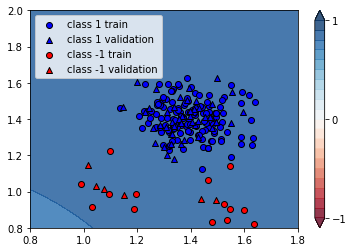

In [60]:
features, num_train, feats_train, Y_train, feats_val, Y_val, X_train, X_val = dataset("/content/sample_data/dataset1.csv")
trainer(features, num_train, feats_train, Y_train, feats_val, Y_val, X_train, X_val, 6, 10)


First X sample (original)  : [0.69115038 2.0106193 ]
First X sample (padded)    : [0.69115038 2.0106193  0.3        0.        ]
First X sample (normalized): [0.32189109 0.93641045 0.1397197  0.        ]
First features sample      : [ 0.28035667 -0.          0.         -1.23970025  1.23970025]
Iter:     1 | Cost: 0.0045990 | Acc train: 0.4888889 | Acc validation: 0.5333333 
Iter:     2 | Cost: 0.0118882 | Acc train: 0.4888889 | Acc validation: 0.5333333 
Iter:     3 | Cost: 0.0271481 | Acc train: 0.4888889 | Acc validation: 0.5333333 
Iter:     4 | Cost: 0.0488968 | Acc train: 0.4888889 | Acc validation: 0.5333333 
Iter:     5 | Cost: 0.0896479 | Acc train: 0.4888889 | Acc validation: 0.5333333 
Iter:     6 | Cost: 0.1583887 | Acc train: 0.4962963 | Acc validation: 0.5333333 
Iter:     7 | Cost: 0.2558240 | Acc train: 0.4962963 | Acc validation: 0.5555556 
Iter:     8 | Cost: 0.3861655 | Acc train: 0.4962963 | Acc validation: 0.5777778 
Iter:     9 | Cost: 0.5336405 | Acc train: 0.49629

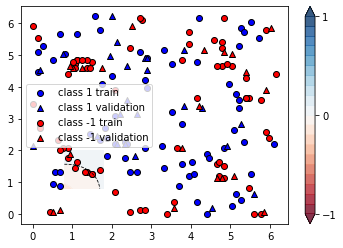

In [68]:
features, num_train, feats_train, Y_train, feats_val, Y_val, X_train, X_val = dataset("/content/sample_data/dataset2.csv")
trainer(features, num_train, feats_train, Y_train, feats_val, Y_val, X_train, X_val, 6, 10)

First X sample (original)  : [-0.68065097  3.76090477]
First X sample (padded)    : [-0.68065097  3.76090477  0.3         0.        ]
First X sample (normalized): [-0.17754151  0.98099725  0.07825223  0.        ]
First features sample      : [ 0.15666462 -0.          0.         -1.39175368  1.39175368]
Iter:     1 | Cost: 0.3752296 | Acc train: 0.0636943 | Acc validation: 0.0188679 
Iter:     2 | Cost: 0.3629651 | Acc train: 0.0636943 | Acc validation: 0.0188679 
Iter:     3 | Cost: 0.3673997 | Acc train: 0.0636943 | Acc validation: 0.0188679 
Iter:     4 | Cost: 0.4123483 | Acc train: 0.0636943 | Acc validation: 0.0188679 
Iter:     5 | Cost: 0.5293773 | Acc train: 0.0700637 | Acc validation: 0.0188679 
Iter:     6 | Cost: 0.7847661 | Acc train: 0.1019108 | Acc validation: 0.0754717 
Iter:     7 | Cost: 1.2589406 | Acc train: 0.8853503 | Acc validation: 0.9811321 
Iter:     8 | Cost: 2.0300228 | Acc train: 0.9426752 | Acc validation: 0.9811321 
Iter:     9 | Cost: 2.9921170 | Acc trai

<ipython-input-63-b452f5ffdea3>:55: UserWarning: No contour levels were found within the data range.
  plt.contour(


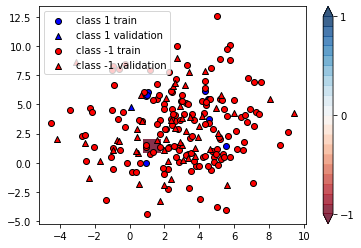

In [65]:
features, num_train, feats_train, Y_train, feats_val, Y_val, X_train, X_val = dataset("/content/sample_data/dataset3.csv")
trainer(features, num_train, feats_train, Y_train, feats_val, Y_val, X_train, X_val, 6, 10)

First X sample (original)  : [3.76991118 3.33008821]
First X sample (padded)    : [3.76991118 3.33008821 0.3        0.        ]
First X sample (normalized): [0.74814379 0.66086035 0.05953539 0.        ]
First features sample      : [ 0.11914124 -0.          0.         -0.72353032  0.72353032]
Iter:     1 | Cost: 0.0019792 | Acc train: 0.8814815 | Acc validation: 0.9111111 
Iter:     2 | Cost: 0.0022830 | Acc train: 0.8814815 | Acc validation: 0.9111111 
Iter:     3 | Cost: 0.0031310 | Acc train: 0.8814815 | Acc validation: 0.9111111 
Iter:     4 | Cost: 0.0048789 | Acc train: 0.8814815 | Acc validation: 0.9111111 
Iter:     5 | Cost: 0.0066684 | Acc train: 0.8814815 | Acc validation: 0.9111111 
Iter:     6 | Cost: 0.0096935 | Acc train: 0.8814815 | Acc validation: 0.9111111 
Iter:     7 | Cost: 0.0125629 | Acc train: 0.8814815 | Acc validation: 0.9111111 
Iter:     8 | Cost: 0.0167400 | Acc train: 0.8814815 | Acc validation: 0.9111111 
Iter:     9 | Cost: 0.0246220 | Acc train: 0.88148

<ipython-input-63-b452f5ffdea3>:55: UserWarning: No contour levels were found within the data range.
  plt.contour(


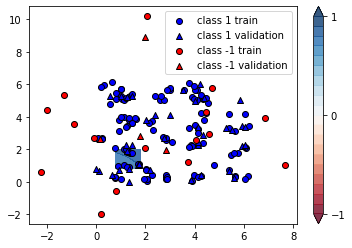

In [67]:
features, num_train, feats_train, Y_train, feats_val, Y_val, X_train, X_val = dataset("/content/sample_data/dataset4.csv")
trainer(features, num_train, feats_train, Y_train, feats_val, Y_val, X_train, X_val, 6, 10)